In [ ]:
import json
import os
from os.path import join
import shutil
import cv2
from multiprocessing import Pool

def copy_file(src: str, dst: str) -> None:
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if not os.path.exists(dst):
        shutil.copy(src , dst)

def gen_yolov5_txt(origin_h: float , 
                    origin_w: float,
                    label_file_path: str, 
                    txt_file_path: str,
                    cls_idx: int):
    with open(label_file_path, 'r') as f:
        data = json.load(f)

    os.makedirs(os.path.dirname(txt_file_path), exist_ok=True)
    rects = [label['points'] for label in data['shapes']]
    lines = []
    for rect in rects:
        lt_x, lt_y = rect[0] # left top x, y
        rb_x, rb_y = rect[1] # right bottom x, y
        center_x = ((lt_x + rb_x) / 2) / origin_w
        center_y = ((lt_y + rb_y) / 2) / origin_h
        w, h = (rb_x - lt_x) / origin_w, (rb_y - lt_y) / origin_h
        w = abs(w)
        h = abs(h)

        line = [int(cls_idx), center_x, center_y, w, h]
        line = [str(element) for element in line]
        line = ' '.join(line) + '\n'
        lines.append(line)
    with open(txt_file_path, 'w') as f:
        f.writelines(lines)

def move_file_and_gen_txt(img_folder: str, 
                        label_folder: str, 
                        img_name: str,
                        new_split_folder: str,
                        new_name_idx: int,
                        cls_idx: int):
    raw_name = img_name.split('.')[0]

    # Rename and move image
    old_img_path = join(img_folder, img_name)
    new_img_path = join(new_split_folder, 'images', f'{new_name_idx}.png')
    copy_file(old_img_path, new_img_path)

    # Generate label txt
    im = cv2.imread(old_img_path)
    h, w, c = im.shape
    label_file_path = os.path.join(label_folder, f'{raw_name}.json')
    txt_file_path = join(new_split_folder, 'labels', f'{new_name_idx}.txt')
    gen_yolov5_txt(h, w, label_file_path, txt_file_path, cls_idx)


if __name__ == '__main__':
    class_names = ['powder_uncover', 'powder_uneven', 'scratch']
    data_root = './data/raw'
    new_data_root = './data/yolov5'
    
    for data_split in ['Train', 'Val']:
        split_folder = join(data_root, data_split)
        new_split_folder = join(new_data_root, data_split)
        name_idx = 0
        for cls_idx, cls_name in enumerate(class_names):
            img_folder = join(split_folder, cls_name, 'image')
            label_folder = join(split_folder, cls_name, 'label')
            for img_name in os.listdir(img_folder):
                raw_name = img_name.split('.')[0]

                # Rename and move image
                old_img_path = join(img_folder, img_name)
                new_img_path = join(new_split_folder, 'images', f'{name_idx}.png')
                
                im = cv2.imread(old_img_path)

                
                name_idx += 1
                break
        break

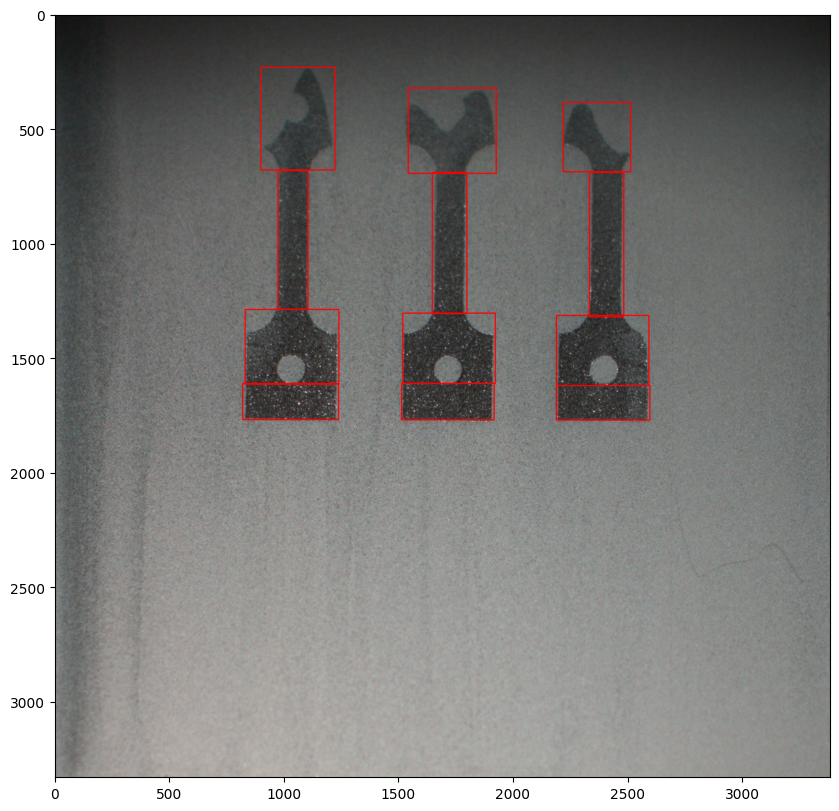

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = './data/yolov5/Train/images/0.png'
label_path = './data/yolov5/Train/labels/0.txt'

im = cv2.imread(img_path)
with open(label_path, 'r') as f:
    lines = f.readlines()
bboxs = []
for line in lines:
    line = [float(e) for e in line.split(' ')]
    cls_idx , center_x, center_y, w, h = line
    cls_idx = int(cls_idx)
    bboxs.append([center_x, center_y, w, h])
bboxs = np.array(bboxs)

bbox_coord = []
im_h, im_w, _ = im.shape
plt.figure(figsize=(10,10))
for bbox in bboxs:
    center_x, center_y, w, h = bbox
    l_x, r_x = (center_x - (w / 2)) * im_w, (center_x + (w / 2)) * im_w
    l_y, r_y = (center_y - (h / 2)) * im_h, (center_y + (h / 2)) * im_h
    cv2.rectangle(im, (int(l_x), int(l_y)), (int(r_x), int(r_y)), (255, 0, 0), 3, cv2.LINE_AA)

    bbox_coord.append([l_x, l_y, r_x, r_y])
plt.imshow(im)

In [20]:
import torch
def box_iou(box1, box2, eps=1e-7):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)
    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)


ious = box_iou(torch.tensor(bbox_coord), torch.tensor(bbox_coord))

In [30]:
from torchvision.ops import masks_to_boxes
import cv2
import torch

img_path = './data/raw/Train/powder_uncover/image/converted_ 0129.png'
im = cv2.imread(img_path, 0)
unique = np.unique(im)
if len(unique) != 2:
    raise ValueError("Some Error in {}".format(mask_path))
ret, im = cv2.threshold(im, unique[1] - 1, 255, cv2.THRESH_BINARY)

In [33]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(im, connectivity=8, ltype=cv2.CV_16U)

In [35]:
rgb_im = cv2.imread(img_path)

In [42]:
rgb_labels = np.repeat(labels, 3, axis=-1)

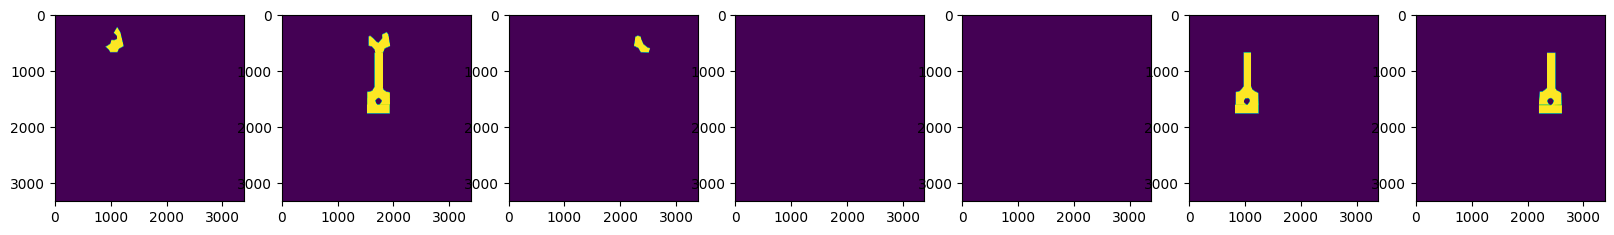

In [48]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20,5))
for i in range(1, num_labels):
    ax = plt.subplot(1, num_labels - 1, i)
    temp = im.copy()
    temp[labels != i] = 0
    ax.imshow(temp)

In [34]:
num_lab

8

In [6]:
import cv2
import numpy as np


img_path = './data/yolov5/Train/images/85.png'
label_path = './data/yolov5/Train/labels/85.txt'

img_root = './data/yolov5/Val/images/'
label_root = './data/yolov5/Val/labels/'

new_root = './data/yolov5_bboxed/Val/images'
os.makedirs(new_root, exist_ok=True)
for name in os.listdir(img_root):
    txt_name = name.split('.')[0] + '.txt'
    img_path = os.path.join(img_root, name)
    label_path = os.path.join(label_root, txt_name)
    im = cv2.imread(img_path)
    with open(label_path, 'r') as f:
        lines = f.readlines()
    bboxs = []
    for line in lines:
        line = [float(e) for e in line.split(' ')]
        cls_idx , center_x, center_y, w, h = line
        cls_idx = int(cls_idx)
        bboxs.append([center_x, center_y, w, h])
    bboxs = np.array(bboxs)
    im_h, im_w, _ = im.shape
    for bbox in bboxs:
        center_x, center_y, w, h = bbox
        l_x, r_x = (center_x - (w / 2)) * im_w, (center_x + (w / 2)) * im_w
        l_y, r_y = (center_y - (h / 2)) * im_h, (center_y + (h / 2)) * im_h
        cv2.rectangle(im, (int(l_x), int(l_y)), (int(r_x), int(r_y)), (255, 0, 0), 3, cv2.LINE_AA)
    cv2.resize(im, (im_h // 2, im_w //2),)
    cv2.imwrite(os.path.join(new_root, name), im)

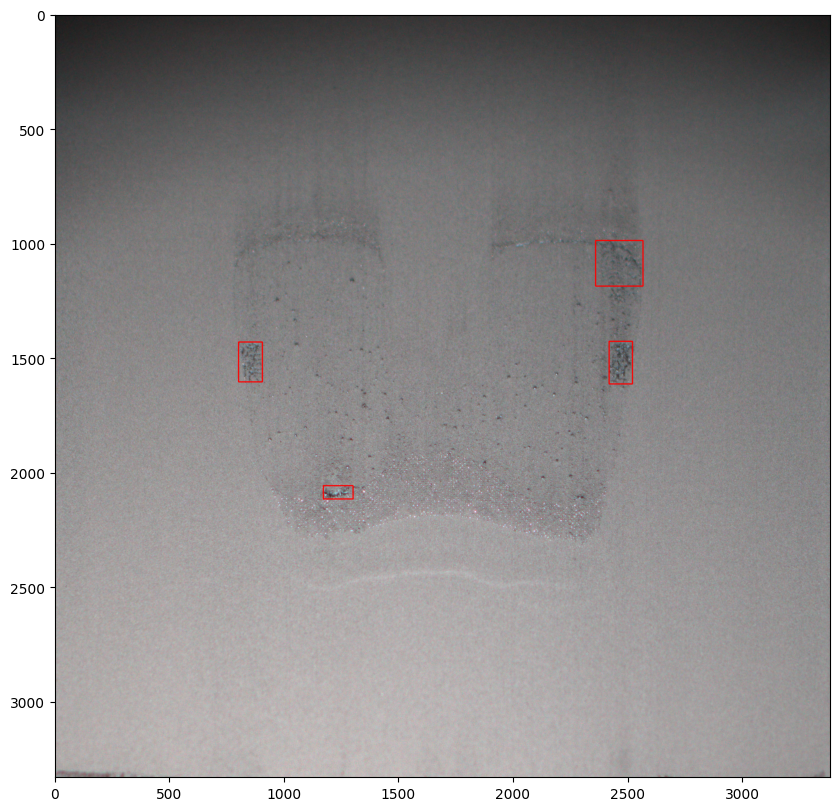

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for bbox in bboxs:
    center_x, center_y, w, h = bbox
    l_x, r_x = (center_x - (w / 2)) * im_w, (center_x + (w / 2)) * im_w
    l_y, r_y = (center_y - (h / 2)) * im_h, (center_y + (h / 2)) * im_h
    cv2.rectangle(im, (int(l_x), int(l_y)), (int(r_x), int(r_y)), (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(im)

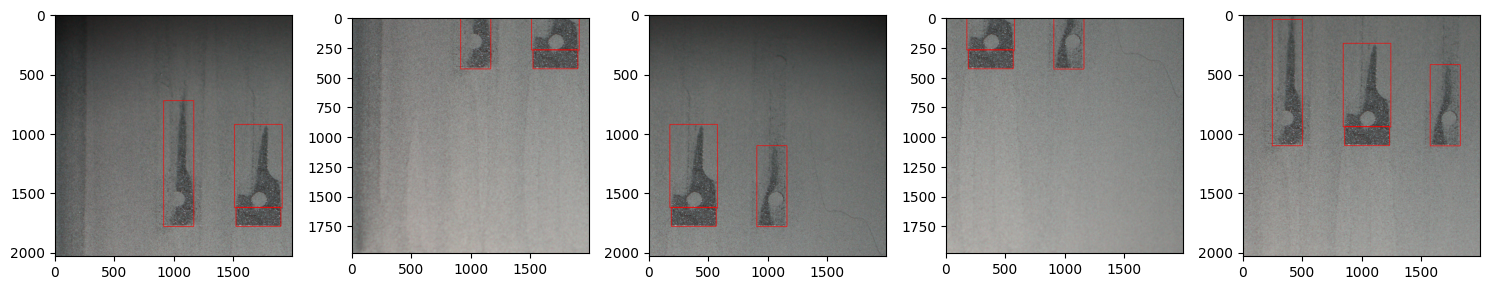

In [4]:
ratio = 0.6
patch_h, patch_w = im_h * ratio, im_w * ratio
coords = [(0, 0, patch_w, patch_h), 
        (im_w - patch_w, 0, im_w , patch_h), 
        (0, im_h - patch_h, patch_w , im_h), 
        (im_w - patch_w, im_h - patch_h, im_w , im_h),
         ((im_w - patch_w) / 2, (im_h - patch_h) / 2, (im_w - patch_w) / 2 + patch_w,  (im_h - patch_h) / 2 + patch_h)]

patchs = []
for bbox in coords:
    l_x, l_y, r_x, r_y = bbox
    patchs.append(im[int(l_x): int(r_x), int(l_y): int(r_y), ...])

plt.figure(tight_layout=True, figsize=(15,8))
for i, patch in enumerate(patchs):
    ax = plt.subplot(1, 5 ,i+1)
    ax.imshow(patch)
plt.tight_layout()

In [5]:
bbox

(0, 0, 2030.3999999999999, 1998.0)